# Train a CNN on the color-based training set.
TensorFlow CNN uses GPU but fewer than 100 patch images fit in GPU RAM.  
Since we can't load all the images, learn to use TensorFlow Data API.

Directory structure is
* cache  
    * train  
        * 0  (green) 2680 files
        * 1   (blue) 3099 files
    * valid  
        * 0  (green) 266 files
        * 1   (blue) 311 files

Filename like F5..208 or F15.209.tif i.e. original_image.patch num.tif  
All prefixes are 3 characters with either one or two dots.  
Patch nums are per category.  
Each file holds a 224x224 patch of a color image.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/cache/"
PATCH_SIZE=224  # matches VGG
BLUE=1
GREEN=0

In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 5779 files belonging to 2 classes.
Found 577 files belonging to 2 classes.


In [4]:
iterator = valid_dataset.take(1)
for x in iterator:
    print(x[0].shape)
    print(x[1])

(32, 224, 224, 3)
tf.Tensor([1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0], shape=(32,), dtype=int32)


In [5]:
# TO DO: normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1./255)

In [6]:
ACTIVATION="tanh"
NUM_CLASSES = 2
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,3]
cnn = keras.models.Sequential([
    kl.Conv2D(filters=64,kernel_size=7,activation=ACTIVATION,padding="SAME",
    input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(64,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(2,activation="softmax")
])
# 10 nodes in the output layer
# corresponds to 10 classes of MNIST clothes.
# cnn.layers[0].weights

In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
181/181 [==============================] - 18s 88ms/step - loss: 0.2135 - accuracy: 0.9280 - val_loss: 0.0318 - val_accuracy: 0.9931
Epoch 2/10
181/181 [==============================] - 15s 83ms/step - loss: 0.0317 - accuracy: 0.9933 - val_loss: 0.0349 - val_accuracy: 0.9931
Epoch 3/10
181/181 [==============================] - 15s 83ms/step - loss: 0.0530 - accuracy: 0.9888 - val_loss: 0.0374 - val_accuracy: 0.9931
Epoch 4/10
181/181 [==============================] - 15s 83ms/step - loss: 0.0224 - accuracy: 0.9952 - val_loss: 0.0330 - val_accuracy: 0.9931
Epoch 5/10
181/181 [==============================] - 15s 83ms/step - loss: 0.0307 - accuracy: 0.9922 - val_loss: 0.0230 - val_accuracy: 0.9948
Epoch 6/10
181/181 [==============================] - 15s 83ms/step - loss: 0.0205 - accuracy: 0.9952 - val_loss: 0.0342 - val_accuracy: 0.9931
Epoch 7/10
181/181 [==============================] - 15s 83ms/step - loss: 0.0133 - accuracy: 0.9972 - val_loss: 0.0205 - val_accuracy:

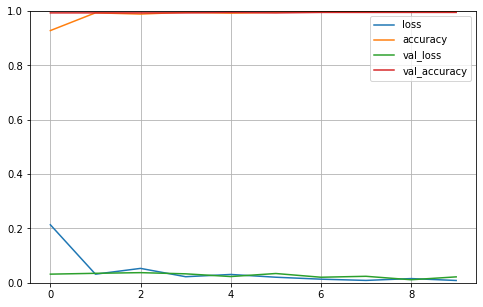

In [9]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

## This worked after a complete reinstall.

After installing nvtop, all of nvidia software stopped working.  
Purge and reinstall was required.